In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [2]:
movies=pd.read_csv("movies.csv")
tag=pd.read_csv("tags.csv")
link=pd.read_csv("links.csv")
ratings=pd.read_csv("ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
tag.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
tag.shape

(3683, 4)

In [7]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
ratings.shape

(100836, 4)

In [9]:
movies['genres']=movies['genres'].str.replace('|',' ')

In [10]:
len(movies.movieId.unique())

9742

In [11]:
len(ratings.movieId.unique())

9724

In [12]:
ratings_f=ratings.groupby('userId').filter(lambda x:len(x)>=55)
movie_list_rating=ratings_f.movieId.unique().tolist()

In [40]:
ratings_f

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [13]:
len(movie_list_rating)

9625

In [14]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100



98.7990145760624

In [15]:
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

59.67213114754099

In [16]:
#filter the movies data frame
movies=movies[movies.movieId.isin(movie_list_rating)]

In [17]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
Mapping_file=dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [19]:
tag.drop(['timestamp'],1,inplace=True)


In [20]:
ratings.drop(['timestamp'],1,inplace=True)

In [21]:
mixed=pd.merge(movies,tag,on='movieId',how='left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [22]:
mixed.size

58660

In [23]:
mixed.fillna("",inplace=True)

In [24]:
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: " %s " % ' '.join(x)))

In [25]:
Final=pd.merge(movies,mixed,on='movieId',how='left')
Final['metadata']=Final[['tag','genres']].apply(lambda x:" ".join(x),axis=1)

In [26]:
Final.shape

(9625, 5)

In [27]:
#tf-idf vectors and truncated svd
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),index=Final.index.tolist())

In [28]:
tfidf_df.shape

(9625, 1675)

In [29]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


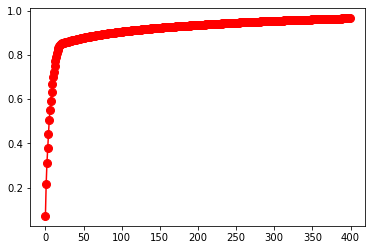

In [30]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=400)
latent_matrix=svd.fit_transform(tfidf_df)
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.show()

In [31]:
n=400
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n],index=Final.title.tolist())

In [32]:
latent_matrix.shape

(9625, 400)

Collaborative latent matrix from user ratings

In [33]:
ratings_f.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [34]:
ratings_f.drop(['timestamp'],1,inplace=True)

In [35]:
ratings_f1=pd.merge(movies[['movieId']],ratings_f,on='movieId',how='right')

In [36]:
ratings_f1.shape

(92729, 3)

In [37]:
ratings_f2=ratings_f1.pivot(index='movieId',columns='userId',values='rating').fillna(0)

In [38]:
ratings_f2.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [39]:
ratings_f2.shape

(9625, 364)

In [50]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=200)
latent_matrix_2=svd.fit_transform(ratings_f2)
latent_matrix_2_df=pd.DataFrame(latent_matrix_2,index=Final.title.tolist())

In [60]:
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),36.391240,-4.958788,14.331820,1.844157,-3.077922,-1.351171,8.341425,-0.561091,-1.898203,1.657855,...,-1.602322,-1.176089,4.211069,-0.796277,0.048883,-0.757861,1.016097,-0.737554,-0.183173,3.671102
Jumanji (1995),20.447499,0.675231,11.354479,-7.325453,-3.505243,3.585610,4.393397,-5.564559,0.434475,0.351438,...,0.611444,-1.182258,-0.696219,-0.496395,-1.405342,1.700554,0.114783,1.456903,0.083127,-0.259805
Grumpier Old Men (1995),8.407816,-5.190801,4.378314,-6.189039,-0.333121,1.924149,-1.548362,0.795946,-3.196047,2.121792,...,0.580161,-0.182558,0.306819,-0.011942,0.220378,0.576261,-0.003321,-0.711917,0.483416,-1.036967
Waiting to Exhale (1995),0.408037,-0.664700,0.739903,-0.202676,-0.498374,1.055409,0.184081,-0.508293,-0.429504,0.086537,...,-0.161548,0.225219,-0.037124,-0.097643,-0.186907,-0.073043,0.313990,0.000660,-0.139674,-0.012440
Father of the Bride Part II (1995),5.755079,-1.757369,3.961287,-3.673278,-3.688047,3.237859,1.140586,-0.690784,-2.171826,1.365961,...,0.667633,0.417884,-0.452825,0.387722,0.683952,-0.432732,-0.064288,0.281607,0.216083,0.076207


In [51]:
latent_matrix_2_df.shape

(9625, 200)

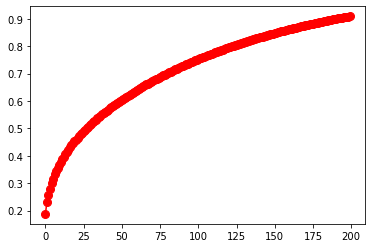

In [52]:

explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.show()

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
a_1=np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)
a_2=np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1,-1)

score1=cosine_similarity(latent_matrix_1_df,a_1).reshape(-1)
score2=cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)

hybrid=((score1+score2)/2.0)

dictdf={'content':score1,'collaborative':score2,'hybrid':hybrid}
similar=pd.DataFrame(dictdf,index=latent_matrix_1_df.index)

similar.sort_values('hybrid',ascending=False,inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
"Bug's Life, A (1998)",0.892530,0.591705,0.742117
Toy Story 2 (1999),0.742126,0.686159,0.714143
"Monsters, Inc. (2001)",0.365427,0.609622,0.487524
Up (2009),0.454292,0.427563,0.440927
Shrek (2001),0.186765,0.667517,0.427141
Aladdin (1992),0.193531,0.637193,0.415362
Toy Story 3 (2010),0.299299,0.505913,0.402606
Groundhog Day (1993),0.165314,0.636618,0.400966
Antz (1998),0.365427,0.435090,0.400258
Ice Age (2002),0.319999,0.476873,0.398436


In [ ]:
,index=latent_matrix_1_df.index